In [ ]:
import pandas as pd
import numpy as np
from scipy import stats # For in-built method to get PCC
import scipy
from sklearn.model_selection import KFold
import pingouin as pg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from zca import zca
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tools
import matplotlib.pyplot as plt
zca = zca.ZCA()

In [ ]:
target = 'Poverty'

all_data = pd.read_csv('../data/raw/states.csv')

scaler.fit(np.array(all_data[target]).reshape(-1, 1))

In [ ]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

In [ ]:
def fit_linear_reg(X,Y,train_i,test_i):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X.iloc[train_i],Y.iloc[train_i])
    RSS = mean_squared_error(Y.iloc[test_i],model_k.predict(X.iloc[test_i])) * len(Y)
    R_squared = model_k.score(X.iloc[test_i],Y.iloc[test_i])
    return RSS, R_squared

In [ ]:
exclude = 'States'

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

p_threshold = .05

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=num_folds)
train_ = []
test_ = []
for train_indices, test_indices in k_fold.split(all_data.index):
    train_.append(train_indices)
    test_.append(test_indices)


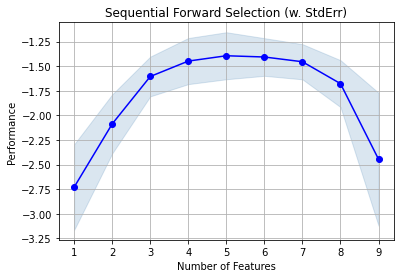

Selected features: (0, 1, 2, 3, 4, 5, 6, 7, 8)
('White', 'Unemployed', 'Income', 'Population')


In [201]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

lr = LinearRegression()

sfbs = sfbs(lr, 
          k_features=len(features), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=10)

sfbs = sfbs.fit(all_data.loc[:, ~all_data.columns.isin([exclude,target])], pd.DataFrame(all_data[target]))
fig = plot_sfbs(sfbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
print('Selected features:', sfbs.k_feature_idx_)

position = list(pd.DataFrame(sfbs.subsets_).loc["avg_score"]).index(pd.DataFrame(sfbs.subsets_).loc["avg_score"].max())

print(sfbs.subsets_[position]['feature_names'])

array([   0.,    0.,   -5., -110.,    0.,    0.,   -5.,    0.,  110.,
       -110.,   95.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [202]:

sig_table = np.zeros(len(all_data.columns))
signs_table = np.zeros(len(all_data.columns))
significance = np.zeros(len(all_data.columns))
sign = np.zeros(len(all_data.columns))
purity = np.zeros(len(all_data.columns))

for it in range(0,len(train_)):
    max_pvalue = 1
    train_index = train_[it]
    test_index = test_[it]
    #display(all_data.iloc[test_index].describe())
    
    subset = pd.concat([all_data[list(sfbs.subsets_[position]['feature_names'])],all_data[target]],axis=1)
    #subset = all_data.iloc[train_index].loc[:, ~all_data.columns.isin([exclude])]
    
    #skip y and states
    set_ = list(sfbs.subsets_[position]['feature_names'])
    #set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        
        max_pname = p_values.idxmax(axis=1)[0]
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):

            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(all_data.columns.isin(winners),1,0)).copy()
    signs_table[all_data.columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)
    
significance = pd.DataFrame(sig_table).T
significance.columns = list(all_data.columns)
display(significance)

sign = pd.DataFrame(signs_table).T
sign.columns = list(all_data.columns)
display(sign)

purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

threshold = 0

chosen = list(purity.T.columns.values[np.array(purity.T>threshold).reshape(len(all_data.columns,))])

display(chosen)    

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0


,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.0,-10.0,0.0,0.0,0.0,0.0,10.0,-10.0,10.0


,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


['White', 'Unemployed', 'Income', 'Population']

In [203]:
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
y_scaled = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
y_scaled.columns=[target]

In [204]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#Initialization variables
Y = all_data[target]
#X = all_data.iloc[:,2:]
X = all_data[chosen]
k = 10
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        #display(all_data.iloc[test_index].describe())
        tmp_result = []
        for it in range(0,len(train_)):
            tmp_result.append(fit_linear_reg(X[list(combo)],Y,train_[it],test_[it]))   #Store temp result )
        
        RSS_list.append(np.average(tmp_result,axis=0)[0])                  #Append lists
        R_squared_list.append(np.average(tmp_result,axis=0)[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Loop...:   0%|          | 0/4 [00:00<?, ?it/s]

In [205]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

In [206]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]


In [207]:
df_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
2,1,136.404405,0.533514,"(Income,)",136.404405,0.533514
7,2,104.298897,0.601244,"(Unemployed, Income)",104.298897,0.601244
10,3,80.230651,0.624001,"(White, Unemployed, Income)",80.230651,0.629563
14,4,72.401282,0.670223,"(White, Unemployed, Income, Population)",72.401282,0.670223


In [208]:
CV_parse = list(df_min[(df_min['RSS']<=(np.min(df_min['RSS'])+np.std(df_min['RSS'])))].sort_values(kind="quicksort", ascending=True, by='RSS',key=abs).iloc[0]['features'])

In [209]:
display(CV_parse)

['White', 'Unemployed', 'Income', 'Population']

In [210]:
zca_data = pd.concat([y_scaled,pd.DataFrame(zca.fit_transform(dataSet[CV_parse]),columns=CV_parse)],axis=1)

In [211]:
zca_data.pcorr()

,Poverty,White,Unemployed,Income,Population
Poverty,1.000000,-0.603937,0.379943,-0.918181,0.359011
White,-0.603937,1.000000,0.229462,-0.554524,0.216820
Unemployed,0.379943,0.229462,1.000000,0.348857,-0.136404
Income,-0.918181,-0.554524,0.348857,1.000000,0.329637
Population,0.359011,0.216820,-0.136404,0.329637,1.000000


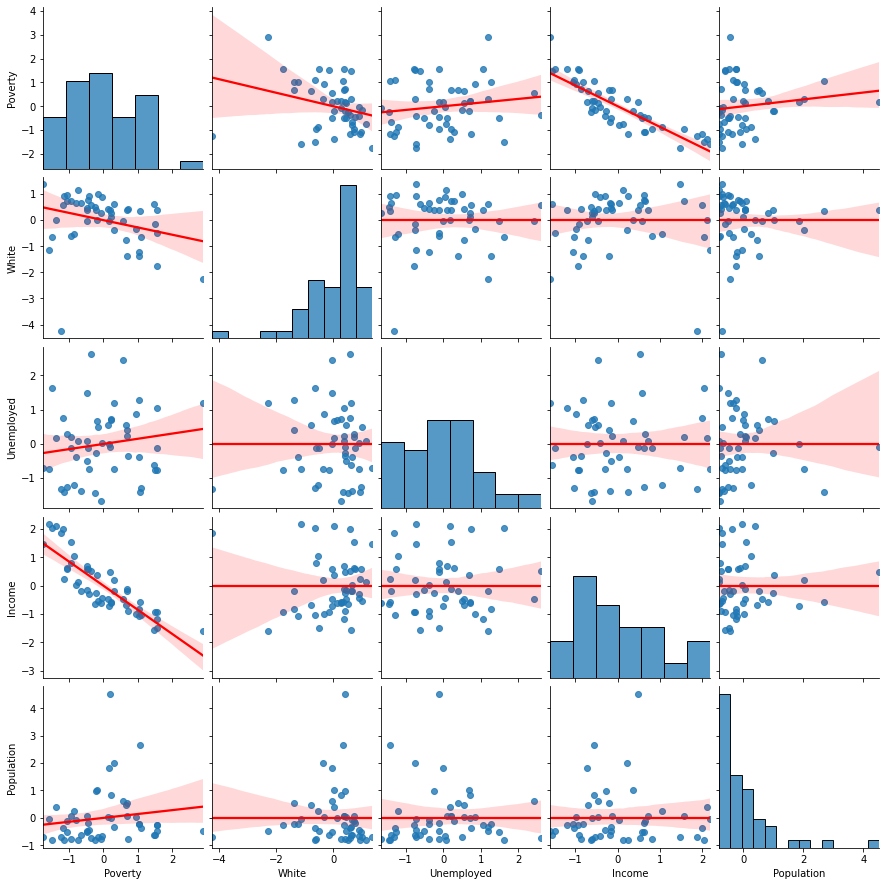

In [212]:
sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [213]:

#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()
fitted = results.predict(X)

In [214]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     70.45
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           8.61e-19
Time:                        06:57:09   Log-Likelihood:                -21.379
No. Observations:                  50   AIC:                             52.76
Df Residuals:                      45   BIC:                             62.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e-16      0.055   1.58e-14      1.000      -0.111       0.111
White         -0.2840      0.056     -5.083      0.000      -0.397      -0.171
Unemployed     0.1540      0.056      2.755      0.008       0.041       0.267
Income        -0.8688      0.056    -15.548      0.000      -0.981      -0.756
Population     0.1442      0.056      2.580      0.013       0.032       0.257
==============================================================================
Omnibus:                        2.601   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.357
Skew:                           0.442   Prob(JB):                        0.308
Kurtosis:                       2.409   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

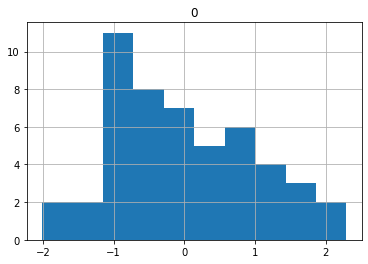

In [215]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

In [216]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     70.45
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           8.61e-19
Time:                        06:57:09   Log-Likelihood:                -21.379
No. Observations:                  50   AIC:                             52.76
Df Residuals:                      45   BIC:                             62.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e-16      0.

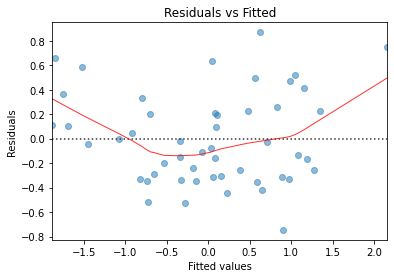

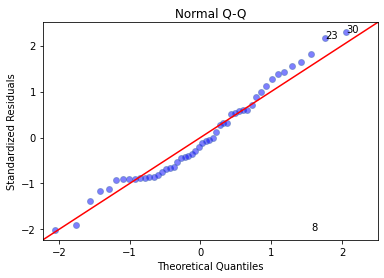

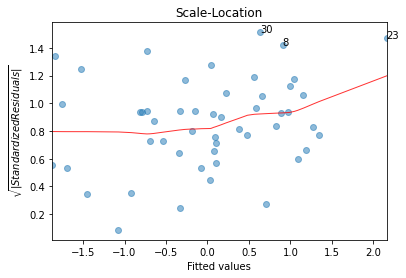

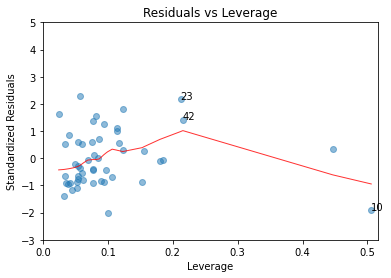

In [217]:
linear_plot = Plot.LinearRegressionResidualPlot(X.values, y.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


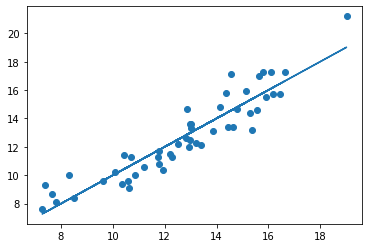

In [218]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0])

m, b = np.polyfit(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], m*results.fittedvalues*scaler.scale_[0] + scaler.mean_[0] + b)

In [219]:
print(m)
print(b)

1.0000000000000007
-4.019436694230463e-15


In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from numpy import *
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
#ENresults = search.fit(X[.loc[:, ~X.columns.isin(['const'])], y)
#ENfitted = ENresults.predict(X.loc[:, ~X.columns.isin(['const'])])
ENresults = search.fit(all_data[CV_parse], y)
ENfitted = ENresults.predict(all_data[CV_parse])

# summarize
print('MAE: %.3f' % ENresults.best_score_)
print('Config: %s' % ENresults.best_params_)

MAE: -0.353
Config: {'alpha': 0.1, 'l1_ratio': 0.0}


Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4834706497728534, tolerance: 0.004999999999999998


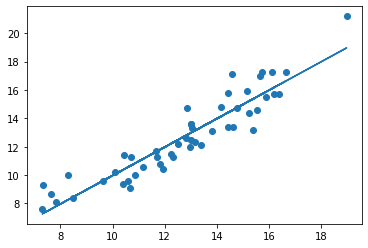

In [221]:
#ENfitted = ENresults.predict(X.loc[:, ~X.columns.isin(['const'])])
ENfitted = ENresults.predict(all_data[CV_parse])
plt.scatter(ENfitted*scaler.scale_[0] + scaler.mean_[0],y*scaler.scale_[0] + scaler.mean_[0])
m, b = np.polyfit(ENfitted*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(ENfitted*scaler.scale_[0] + scaler.mean_[0], m*ENfitted*scaler.scale_[0] + scaler.mean_[0] + b)

In [222]:

# ransac regression on a dataset with outliers
import pandas as pd
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()




Mean MAE: 0.433 (0.113)


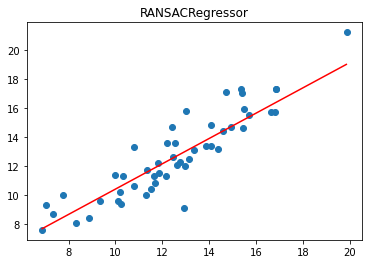

In [223]:
# define the model
model = RANSACRegressor()
# evaluate model
#Rresults = evaluate_model(X.loc[:, ~X.columns.isin(['const'])], y, model)
Rresults = evaluate_model(all_data[CV_parse], y, model)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults), std(Rresults)))
# plot the line of best fit
Rresults = model.fit(all_data[CV_parse],y)
RFitted = Rresults.predict(all_data[CV_parse])
plot_best_fit(RFitted.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y*scaler.scale_[0] + scaler.mean_[0], model)

In [224]:
print("OLS: " + str(mean_squared_error(y,fitted) * len(y)))
print("EN: " + str(mean_squared_error(y,ENfitted) * len(y)))
print("Robust: " + str(mean_squared_error(y,RFitted) * len(y)))

OLS: 6.8846403927757125
EN: 6.890341427114508
Robust: 9.46635532964568
